In [19]:
import json
from os import path, walk, makedirs
from sys import exit, stderr
import os
from cv2 import fillPoly
import cv2
import numpy as np
from shapely import wkt
from shapely.geometry import mapping, Polygon
from shapely.wkt import loads
from skimage.io import imread
from tqdm import tqdm
import imantics 
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [20]:
root_folder = r'C:\Users\prath\VBL'
image_folder = path.join(root_folder, 'Images')
json_folder = path.join(root_folder, 'Labels')
mask_folder = path.join(root_folder, 'Masks')

In [21]:
def mask_for_polygon(poly, im_size=(288, 288)):
    img_mask = np.zeros(im_size, np.uint8)
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords)]
    interiors = [int_coords(pi.coords) for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask

def process_image(json_file):
    jfile = json.load(open(json_file))
    msk = np.zeros((288, 288), dtype='uint8')
    
    for feat in jfile['features']['xy']:
        poly = loads(feat['wkt'])
        _msk = mask_for_polygon(poly)
        msk[_msk > 0] = 255       
    cv2.imwrite(json_file.replace('Labels', 'Masks').replace('.json', '.png'), msk, [cv2.IMWRITE_PNG_COMPRESSION, 9])

In [22]:
#getting image dimensions
def get_dims(chip_file):
    pil_img = imread(chip_file)
    img = np.array(pil_img)
    w, h, c = img.shape
    return w, h, c

In [23]:
# getting polygon coordinates from json files       
def get_coord(chip_json):
    coordinates = {}
    for i in chip_json['features']['xy']:
        i_shape = wkt.loads(i['wkt'])
        coords = list(mapping(i_shape)['coordinates'][0])
        coordinates[i['properties']['uid']] = (np.array(coords, np.int32))
    return coordinates

In [24]:
def save_mask(masked_polygons, mask_folder, mask_file_name):
    for m in masked_polygons:
        output = path.join(mask_folder, mask_file_name + '_{}.png'.format(m))
        cv2.imwrite(output, masked_polygons[m])

In [25]:
def load_jsons(json_full_path):
    jdata = json.load(open(json_full_path))
    return jdata

In [26]:
#Iterating through the folder containing json files and storing their names 
jsons = [j for j in next(walk(json_folder))[2]]

#iterating through json files, and making sure that are no files with other formats among them
for j in tqdm([j for j in jsons if j.endswith('json')], unit='poly', leave=False):
        #split the name of the file and the format, and replace .json by .png to access the images, as they have the same name standard 
        chip_img_id = path.splitext(j)[0] + '.png'
        #get file name without the extension. This will be used as the name of the mask file
        mask_file_name = path.splitext(j)[0]
        
        #reading json files
        json_full_path = path.join(json_folder, j)
        chip_json = load_jsons(json_full_path)

        #getting image dimensions
        chip_file = path.join(image_folder, chip_img_id)
        chip_size = get_dims(chip_file)

        # getting polygon coordinates from json files
        coordinates = get_coord(chip_json)
        
        #creating masks for each polygon using border=2 and saving mask images 
        process_image(json_full_path)

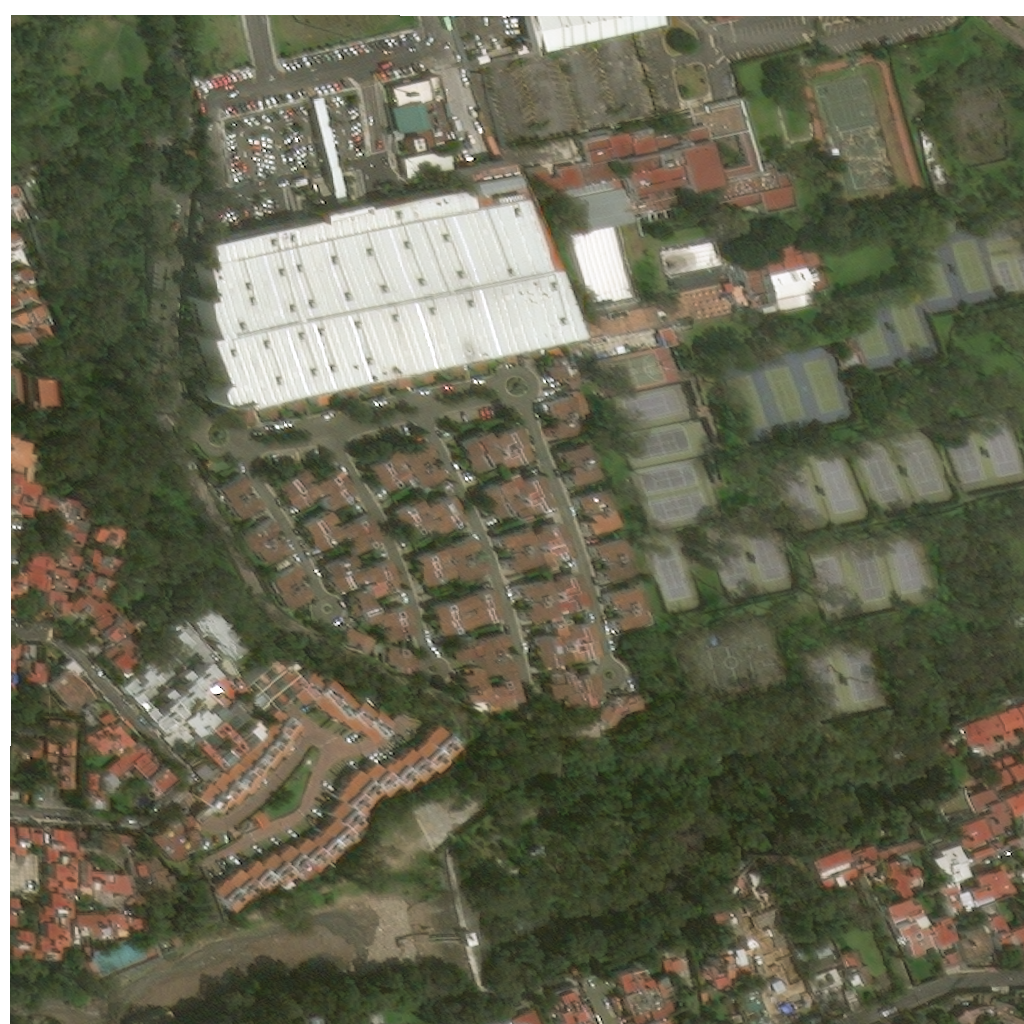

In [27]:
from IPython.display import Image
Image(filename='C:\\Users\\prath\\VBL\\Images\\mexico-earthquake_00000001_post_disaster.png', width=200)

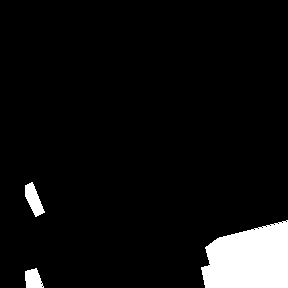

In [28]:
Image(filename='C:\\Users\\prath\\VBL\\Masks\\mexico-earthquake_00000001_post_disaster.png', width=200)

##We will now do preprocessing.The aim of the project is to classify the buildings by the degree of damage,but the satellite images are not at the building level,so now we need to recognize buildings in each image and then create a seperate image for each building and label it accordingly.

In [52]:
#Importing a new set of libraries to continue with the proprocessing
from PIL import Image
import time
import pandas as pd
import os
import cv2
import math
from tqdm import tqdm
import random
import logging
import datetime
import shapely
from collections import defaultdict
from sklearn.model_selection import train_test_split
logging.basicConfig(level=logging.INFO)

In [53]:
damage = defaultdict(lambda: 0)
damage['destroyed'] = 3
damage['major-damage'] = 2
damage['minor-damage'] = 1
damage['no-damage'] = 0

In [54]:
output_folder = r'C:\\Users\\prath\\VBL\\Model_Outputs\\Output'
output_mask_folder = r'C:\\Users\\prath\\VBL\\Model_Outputs\\Output_Masks'

In [61]:
# This function finds the corners of each polygon.
# As it is a polygon, we are using the max coordinate on both x and y axis to create a square image
# The function was adapated to crop mask images as well

def process_img(img_array, polygon_pts, scale_pct):
    """Process Raw Data into
            Args:
                img_array (numpy array): numpy representation of image.
                polygon_pts (array): corners of the building polygon.
            Returns:
                numpy array: .
    """
    if len(img_array.shape) == 3:
        height, width, _ = img_array.shape
    else:
        height, width = img_array.shape

    xcoords = polygon_pts[:, 0]
    ycoords = polygon_pts[:, 1]
    xmin, xmax = np.min(xcoords), np.max(xcoords)
    ymin, ymax = np.min(ycoords), np.max(ycoords)

    xdiff = xmax - xmin
    ydiff = ymax - ymin

    #Extend image by scale percentage
    xmin = max(int(xmin - (xdiff * scale_pct)), 0)
    xmax = min(int(xmax + (xdiff * scale_pct)), width)
    ymin = max(int(ymin - (ydiff * scale_pct)), 0)
    ymax = min(int(ymax + (ydiff * scale_pct)), height)

    
    if len(img_array.shape) == 3:
        return img_array[ymin:ymax, xmin:xmax, :]
    else:
        return img_array[ymin:ymax, xmin:xmax]

In [60]:
# Creating one separate image per polygon 
# We also calculated the image mean and subtracted from the original array

x = []
y = []

images = [i for i in next(os.walk(image_folder))[2]]
for img in tqdm(images):
    #Opening each image and transforming it into a numpy array and subtracting the image mean
    imgage_obj = Image.open(path.join(image_folder, img))
    image_array = np.array(imgage_obj)
    #image_array = image_array - image_array.mean()
        
    #Getting the respective label for each picture
    label_path = path.join(image_folder.replace('Images', 'Labels'), img.replace('png', 'json'))
    label_file = open(label_path)
    label_data = json.load(label_file)
    
    mask_path = path.join(image_folder.replace('Images', 'Masks'), img)
    mask_obj = Image.open(mask_path)
    mask_array = np.array(mask_obj)


    for building in label_data['features']['xy']:
        #As pre-disaster images don't have a label, we assinged no-demage to them
        try:
            damage_type = building['properties']['subtype']
        except:
            damage_type = "no-damage"
            continue

        #Creating two vectors, one with the label (y) and the other with the building uuid(X).
        #Together whey will become a dataset thet will help us when training the model with flow_from_dataset
        building_uuid = building['properties']['uid'] + ".png"
        y.append(damage[damage_type])
        x.append(building_uuid)
        
        #Creating separate images for each building based on the corners of the polygons
        #Same process is repeated for masks
        i_shape = shapely.wkt.loads(building['wkt'])
        polygon_corners = np.array(list(i_shape.exterior.coords))
        poly_img = process_img(image_array, polygon_corners, 0.8)
        poly_mask = process_img(mask_array, polygon_corners, 0.8)
        cv2.imwrite(output_folder + "/" + building_uuid, poly_img)
        cv2.imwrite(output_mask_folder + "/" + building_uuid, poly_mask)

  0%|                                                                                          | 0/116 [00:00<?, ?it/s]


error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'
